<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/biggan/notebooks/biggan_explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

path

`src/gan/biggan/notebooks/`

## CelebA

In [1]:
!mkdir -p data
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip -O data/celeba.zip
!unzip -q -o -d ./data data/celeba.zip
!rm -rf data/celeba.zip

--2020-05-10 16:00:26--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.33
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘data/celeba.zip’

data/celeba.zip     100%[===================>]   1.34G  74.6MB/s    in 19s     

2020-05-10 16:00:45 (73.5 MB/s) - ‘data/celeba.zip’ saved [1443490838/1443490838]



In [2]:
!ls data/img_align_celeba -1 | wc -l

202599


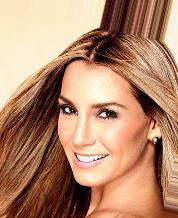

In [43]:
from PIL import Image

img = Image.open("data/img_align_celeba/000001.jpg")
img

In [42]:
img.size

(178, 218)

- PIL.Image.Imgae
    - [WxH]

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

input, target = next(iter(datasets.ImageFolder("data", transform=transforms.Compose([transforms.ToTensor()]))))
input.size()

torch.Size([3, 218, 178])

- torch.Tensor
    - [BxCxHxW]

## DataLoader

In [5]:
!python3 -V

Python 3.6.9


In [6]:
!pip freeze | grep torch

torch==1.5.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.6.0+cu101


In [0]:
import os
import torch
from torchvision import datasets
from torchvision import transforms

In [8]:
print(torch.cuda.get_device_name())
print(torch.cuda.is_available())

Tesla P100-PCIE-16GB
True


In [0]:
class CelebALoader():
    def __init__(self, train=True, dataset="celeba", image_path="data/", 
                 image_size=128, batch_size=16, shuffle=True):
        self.dataset = dataset
        self.path = image_path
        self.imsize = image_size
        self.batch = batch_size
        self.shuffle = shuffle
        self.train = train

    def transform(self, resize, totensor, normalize, centercrop):
        options = []
        if centercrop:
            options.append(transforms.CenterCrop(160))
        if resize:
            options.append(transforms.Resize((self.imsize,self.imsize)))
        if totensor:
            options.append(transforms.ToTensor())
        if normalize:
            options.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        transform = transforms.Compose(options)
        return transform

    def load_celeb(self):
        transforms = self.transform(True, True, True, True)
        dataset = datasets.ImageFolder(self.path, transform=transforms)
        return dataset

    def get_loader(self):
        dataset = self.load_celeb()

        print(f"dataset: {len(dataset)}")
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch,
                                             shuffle=self.shuffle, num_workers=4,
                                             drop_last=True)
        return loader

In [10]:
celeba_loader = CelebALoader().get_loader()

dataset: 202599


In [11]:
input, target = next(iter(celeba_loader))

print(input.size())
print(target.size())

torch.Size([16, 3, 128, 128])
torch.Size([16])


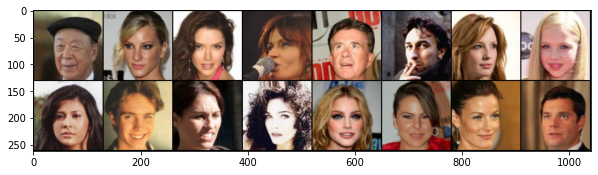

In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(input, normalize=True).permute((1, 2, 0)).numpy());

## Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm

This implementation uses `nn.BatchNorm2d` instead of `CrossReplicaBN`

In [0]:
def init_linear(linear):
    torch.nn.init.xavier_uniform_(linear.weight)
    linear.bias.data.zero_()

In [0]:
def init_conv(conv, glu=True):
    torch.nn.init.xavier_uniform_(conv.weight)
    if conv.bias is not None:
        conv.bias.data.zero_()

In [0]:
def leaky_relu(input):
    return F.leaky_relu(input, negative_slope=0.2)

### Self-Attention

In [0]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim, activation=F.relu):
        super(SelfAttention, self).__init__()

        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim,    kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1)

        init_conv(self.query_conv)
        init_conv(self.key_conv)
        init_conv(self.value_conv)

    def forward(self,x):
        """
            inputs :
                x : input feature maps(B, C, H, W)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        batch, channels, height, width = x.size()
        # [BxCxHxW] -> [BxCx(H*W)]
        proj_query  = self.query_conv(x).view(batch, -1, height*width)
        proj_key    =  self.key_conv(x) .view(batch, -1, height*width)

        # [Bx(H*W)xC]x[BxCx(H*W)] -> [Bx(H*W)x(H*W)]
        # slow implementation: torch.einsum('ijk,ikl->ijl', proj_query.permute(0,2,1), proj_key)
        energy = torch.bmm(proj_query.permute(0,2,1), proj_key)
        attention = self.softmax(energy)

        # [BxCxHxW] -> [BxCx(H*W)]
        proj_value = self.value_conv(x).view(batch, -1, height*width)

        # [BxCx(H*W)]x[Bx(H*W)x(H*W)]
        out = torch.bmm(proj_value, attention.permute(0,2,1))
        out = out.view(batch, channels, height, width)
        
        out = self.gamma*out + x
        return out

In [0]:
test = torch.randn(10, 32, 64, 64)

In [19]:
nn.Conv2d(32, 4, kernel_size=1)(test).size()

torch.Size([10, 4, 64, 64])

In [20]:
SelfAttention(in_dim=32)(test).size()

torch.Size([10, 32, 64, 64])

### Conditional Norm

In [0]:
class ConditionalNorm(nn.Module):
    def __init__(self, in_channel, n_condition=148):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_channel, affine=False)

        self.embed = nn.Linear(n_condition, in_channel* 2)
        self.embed.weight.data[:, :in_channel] = 1
        self.embed.weight.data[:, in_channel:] = 0

    def forward(self, input, class_id):
        out = self.bn(input)
        # print(class_id.dtype)
        # print('class_id', class_id.size()) # torch.Size([4, 148])
        # print(out.size()) #torch.Size([4, 128, 4, 4])
        # class_id = torch.randn(4,1)
        # print(self.embed)
        embed = self.embed(class_id)
        # print('embed', embed.size())
        gamma, beta = embed.chunk(2, 1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        # print(beta.size())
        out = gamma * out + beta

        return out

In [0]:
test = torch.randn(10, 32, 64, 64)
class_id = torch.randn(10, 128)

In [23]:
out = nn.BatchNorm2d(32, affine=False)(test)
out.size()

torch.Size([10, 32, 64, 64])

In [24]:
embed = nn.Linear(128, 32*2)(class_id)
embed.size()

torch.Size([10, 64])

In [25]:
gamma, beta = embed.chunk(2, 1)

print(gamma.size())
print(beta.size())

torch.Size([10, 32])
torch.Size([10, 32])


In [26]:
gamma = gamma.unsqueeze(2).unsqueeze(3)
beta = beta.unsqueeze(2).unsqueeze(3)

print(gamma.size())
print(beta.size())

torch.Size([10, 32, 1, 1])
torch.Size([10, 32, 1, 1])


In [27]:
out_affined = gamma * out + beta
out_affined.size()

torch.Size([10, 32, 64, 64])

### GBlock

In [0]:
class GBlock(nn.Module):

    def __init__(self, in_feat, out_feat, kernel_size=[3, 3],
                 padding=1, stride=1, n_class=None, bn=True,
                 activation=F.relu, upsample=True, downsample=False):
        super(GBlock, self).__init__()

        gain = 2 ** 0.5
        self.conv0 = spectral_norm(nn.Conv2d(in_feat, out_feat, kernel_size,
                                             stride, padding, bias=True if bn else True))
        self.conv1 = spectral_norm(nn.Conv2d(out_feat, out_feat, kernel_size,
                                             stride, padding, bias=True if bn else True))
        
        self.skip_proj = False
        if in_feat != out_feat or upsample or downsample:
            self.conv_sc = spectral_norm(nn.Conv2d(in_feat, out_feat, 1, 1, 0))
            self.skip_proj = True

        self.upsample = upsample
        self.downsample = downsample
        self.activation = activation
        self.bn = bn
        if bn:
            self.HyperBN = ConditionalNorm(in_feat, 148)
            self.HyperBN_1 = ConditionalNorm(out_feat, 148)

    def forward(self, input, condition=None):
        out = input

        if self.bn:
            # print('condition',condition.size()) #condition torch.Size([4, 148])
            out = self.HyperBN(out, condition)
        out = self.activation(out)
        if self.upsample:
            # TODO different form papers
            out = F.interpolate(out, scale_factor=2, mode="bicubic")
        out = self.conv0(out)
        if self.bn:
            out = self.HyperBN_1(out, condition)
        out = self.activation(out)
        out = self.conv1(out)

        if self.downsample:
            out = F.avg_pool2d(out, 2)

        if self.skip_proj:
            skip = input
            if self.upsample:
                # TODO different form papers
                skip = F.interpolate(skip, scale_factor=2, mode="bicubic")
            skip = self.conv_sc(skip)
            if self.downsample:
                skip = F.avg_pool2d(skip, 2)
        else:
            skip = input

        return out + skip

In [0]:
test = torch.randn(10, 32, 64, 64)
class_id = torch.randn(10, 148)

In [30]:
GBlock(32, 64)

GBlock(
  (conv0): Conv2d(32, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (conv_sc): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (HyperBN): ConditionalNorm(
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (embed): Linear(in_features=148, out_features=64, bias=True)
  )
  (HyperBN_1): ConditionalNorm(
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (embed): Linear(in_features=148, out_features=128, bias=True)
  )
)

In [31]:
GBlock(32, 64)(test, class_id).size()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([10, 64, 128, 128])

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, code_dim=100, n_class=1000, chn=96, debug=False):
        super(Generator, self).__init__()

        self.linear = spectral_norm(nn.Linear(n_class, 128, bias=False))
        self.first_view = 16 * chn
        self.G_linear = spectral_norm(nn.Linear(20, 4*4*16*chn))

        self.conv = nn.ModuleList([
            GBlock(16*chn, 16*chn, n_class=n_class),
            GBlock(16*chn,  8*chn, n_class=n_class),
            GBlock( 8*chn,  4*chn, n_class=n_class),
            GBlock( 4*chn,  2*chn, n_class=n_class),
            SelfAttention(  2*chn),
            GBlock( 2*chn,    chn, n_class=n_class),
        ])

        self.bn = nn.BatchNorm2d(1*chn)
        self.sample = spectral_norm(nn.Conv2d(1*chn, 3, 3, 1, 1))

    def forward(self, input, class_id):
        
        # if Z=100, [BxZ] -> [Bx20]x5
        codes = torch.split(input, 20, 1)
        # [BxNClass] -> [Bx128]
        class_emb = self.linear(class_id)


        out = self.G_linear(codes[0])
        # out = out.view(-1, 1536, 4, 4)
        out = out.view(-1, self.first_view, 4, 4)
        ids = 1
        for i, conv in enumerate(self.conv):
            if isinstance(conv, GBlock):
                conv_code = codes[ids]
                ids = ids+1
                condition = torch.cat([conv_code, class_emb], 1)
                # print('condition',condition.size()) #torch.Size([4, 148])
                out = conv(out, condition)
            else:
                out = conv(out)

        out = self.bn(out)
        out = F.relu(out)
        out = self.sample(out)

        return torch.tanh(out)

In [51]:
len(torch.split(torch.randn(10, 120), 20, 1))

6

In [52]:
Generator()(torch.randn(10, 120), torch.randn(10, 1000)).size()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([10, 3, 128, 128])

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, n_class=1000, chn=96, debug=False):
        super(Discriminator, self).__init__()

        def conv(in_channel, out_channel, downsample=True):
            return GBlock(in_channel, out_channel,
                          bn=False,
                          upsample=False, downsample=downsample)

        gain = 2 ** 0.5
        self.pre_conv = nn.Sequential(spectral_norm(nn.Conv2d(3, 1*chn, 3,padding=1)),
                                      nn.ReLU(inplace=True),
                                      spectral_norm(nn.Conv2d(1*chn, 1*chn, 3,padding=1)),
                                      nn.AvgPool2d(2))
        self.pre_skip = spectral_norm(nn.Conv2d(3, 1*chn, 1))

        self.conv = nn.Sequential(conv(1*chn, 1*chn, downsample=True),
                                  SelfAttention(1*chn),
                                  conv(1*chn, 2*chn, downsample=True),    
                                  conv(2*chn, 4*chn, downsample=True),
                                  conv(4*chn, 8*chn, downsample=True),
                                  conv(8*chn, 16*chn, downsample=True),
                                  conv(16*chn, 16*chn, downsample=False))

        self.linear = spectral_norm(nn.Linear(16*chn, 1))

        self.embed = nn.Embedding(n_class, 16*chn)
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.embed = spectral_norm(self.embed)

    def forward(self, input, class_id):
        
        out = self.pre_conv(input)
        out = out + self.pre_skip(F.avg_pool2d(input, 2))
        # print(out.size())
        out = self.conv(out)
        out = F.relu(out)
        out = out.view(out.size(0), out.size(1), -1)
        out = out.sum(2)
        out_linear = self.linear(out).squeeze(1)
        embed = self.embed(class_id)

        prod = (out * embed).sum(1)

        # if self.debug == debug:
        #     print('class_id',class_id.size())
        #     print('out_linear',out_linear.size())
        #     print('embed', embed.size())
        #     print('prod', prod.size())

        return out_linear + prod

In [0]:
test = torch.randn(10, 3, 128, 128)
class_id = torch.randint(0, 1000, (10,))

In [37]:
class_id.size()

torch.Size([10])

In [38]:
nn.Embedding(1000, 256)(torch.nn.functional.one_hot(class_id, num_classes=1000)).size()

torch.Size([10, 1000, 256])

In [39]:
nn.Embedding(1000, 256)(torch.randint(0, 1000, (10,))).size()

torch.Size([10, 256])

In [40]:
Discriminator()(test, class_id)

tensor([-0.1818,  0.0073,  0.4613, -0.2668, -0.0081,  0.2157,  0.1308, -0.1122,
        -0.0478, -0.0018], grad_fn=<AddBackward0>)

In [41]:
Discriminator()(test, class_id).size()

torch.Size([10])